In [67]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')
df['dist'] = ((df['x_pos'] - df['x_target'])**2 + (df['y_pos'] - df['y_target'])**2 + (df['z_pos'] - df['z_target'])**2)**0.5
angle = np.array(df['y_angle'])
dist = np.array(df['dist'])

def find_angle_for_distance(target_distance, angles, distances):
    """
    주어진 목표 거리(target_distance)에 대응하는 발사 각도를
    선형 보간법으로 계산합니다.
    1. distances 배열을 오름차순으로 정렬하면서 대응되는 angles도 함께 재정렬
    2. np.interp를 사용해 보간(interpolation)한 값을 반환
    """
    # (1) 거리 기준으로 정렬
    sort_idx = np.argsort(distances)
    sorted_distances = distances[sort_idx]
    sorted_angles = angles[sort_idx]
    
    # (2) 목표 거리가 측정 범위 안에 있는지 체크
    if not (sorted_distances.min() <= target_distance <= sorted_distances.max()):
        raise ValueError(f"목표 거리 {target_distance}m 은(는) 측정된 거리 범위를 벗어납니다.")
    
    
    # (3) 선형 보간
    required_angle = np.interp(target_distance, sorted_distances, sorted_angles)
    return required_angle

# ── 사용 예시 ──
# 내 탱크 좌표 (x0, y0)와 목표 좌표 (xt, yt)가 있다고 가정
x, z = map(float, input().split())
x0, y0, z0 = (x, 8.0, z)
xt, yt, zt = (135.4600, 8.6, 276.8700)
# 2D 유클리디언 거리 계산
target_distance = np.sqrt((xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2)

angle_to_fire = find_angle_for_distance(target_distance, angle, dist)
print(f"목표 거리 {target_distance:.2f}m 에 도달하려면 약 {angle_to_fire:.2f}° 로 쏘세요.")

목표 거리 49.85m 에 도달하려면 약 1.57° 로 쏘세요.


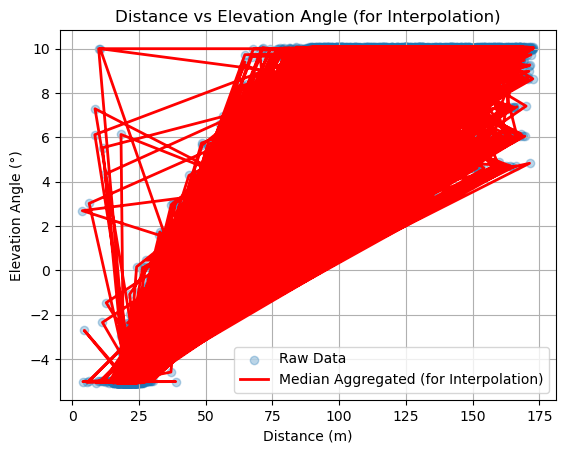

In [51]:
import matplotlib.pyplot as plt

plt.scatter(df['dist'], df['y_angle'], alpha=0.3, label='Raw Data')
plt.plot(dist, angle, color='red', label='Median Aggregated (for Interpolation)', linewidth=2)
plt.xlabel("Distance (m)")
plt.ylabel("Elevation Angle (°)")
plt.title("Distance vs Elevation Angle (for Interpolation)")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# 거리 계산
df['dist'] = np.sqrt(
    (df['x_pos'] - df['x_target'])**2 +
    (df['y_pos'] - df['y_target'])**2 +
    (df['z_pos'] - df['z_target'])**2
)

# ✅ 130m 넘는 거리 제거 (이상치)
df = df[df['dist'] <= 130]

# ✅ 21m보다 가까운 거리 제거 (이상치)
df = df[df['dist'] > 21]

# ✅ 각 y_angle별 중앙값 거리 계산
grouped = df.groupby('y_angle')['dist'].median().reset_index()

# 보간용 배열 생성
angles = np.array(grouped['y_angle'])        # y축 각도
distances = np.array(grouped['dist'])        # 중앙값 거리

def find_angle_for_distance(target_distance, angles, distances):
    # 거리 기준 정렬
    sort_idx = np.argsort(distances)
    sorted_distances = distances[sort_idx]
    sorted_angles = angles[sort_idx]
    
    # 범위 확인
    if not (sorted_distances.min() <= target_distance <= sorted_distances.max()):
        raise ValueError(f"Target distance {target_distance:.2f}m is out of interpolation range.")
    
    # 선형 보간
    return np.interp(target_distance, sorted_distances, sorted_angles)

# ── 사용 예시 ──
x, z = map(float, input("Enter your tank X Z position: ").split())
x0, y0, z0 = (x, 8.0, z)
xt, yt, zt = (135.4600, 8.6, 276.8700)
target_distance = np.sqrt((xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2)

angle_to_fire = find_angle_for_distance(target_distance, angles, distances)
print(f"🎯 Target distance {target_distance:.2f}m → Required elevation angle: {angle_to_fire:.2f}°")



🎯 Target distance 49.86m → Required elevation angle: 1.33°


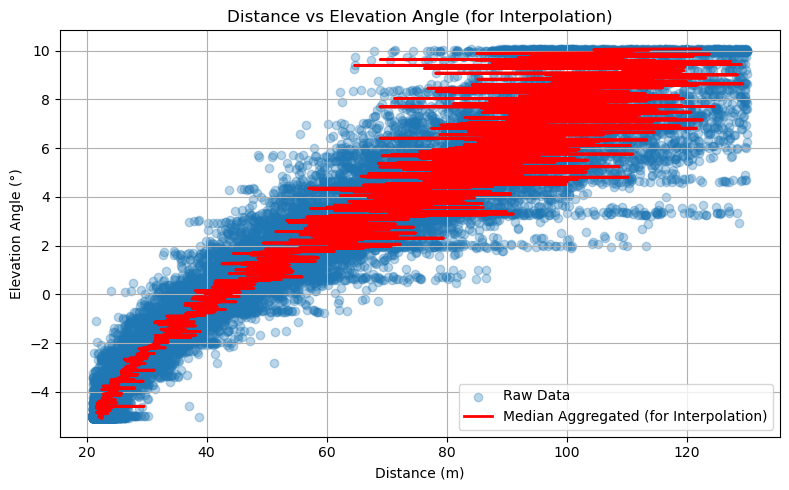

In [58]:
# ── 시각화 ──
plt.figure(figsize=(8, 5))
plt.scatter(df['dist'], df['y_angle'], alpha=0.3, label='Raw Data')
plt.plot(distances, angles, color='red', label='Median Aggregated (for Interpolation)', linewidth=2)
plt.xlabel("Distance (m)")
plt.ylabel("Elevation Angle (°)")
plt.title("Distance vs Elevation Angle (for Interpolation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로딩
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# 거리 계산
df['dist'] = np.sqrt((df['x_pos'] - df['x_target'])**2 + 
                     (df['y_pos'] - df['y_target'])**2 + 
                     (df['z_pos'] - df['z_target'])**2)

# 거리 130m 이상은 이상치로 제거
df = df[df['dist'] <= 130]

# ✅ 21m보다 가까운 거리 제거 (이상치)
df = df[df['dist'] > 21]

# 거리 값 소수점 제거 → binning
df['dist_bin'] = df['dist'].round().astype(int)

# 각 거리 bin에 대해 count, median
grouped = df.groupby('dist_bin')['y_angle'].agg(['count', 'median']).reset_index()

# ▶️ 임계치보다 작은 빈도는 제거
threshold = 3
filtered = grouped[grouped['count'] >= threshold]

# 거리-각도 배열
distances = filtered['dist_bin'].values
angles = filtered['median'].values

# 보간 함수 정의
def find_angle_for_distance(target_distance, distances, angles):
    if not (distances.min() <= target_distance <= distances.max()):
        raise ValueError(f"{target_distance:.1f}m: 거리 범위를 벗어남.")
    return np.interp(target_distance, distances, angles)

# 🎯 예시 입력
x0, z0 = float(input("내 전차 x: ")), float(input("내 전차 z: "))
xt, yt, zt = 135.46, 8.6, 276.87
y0 = 8.0

target_dist = np.sqrt((xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2)
target_angle = find_angle_for_distance(target_dist, distances, angles)

print(f"🎯 거리: {target_dist:.2f}m → 권장 y각도: {target_angle:.2f}°")


🎯 거리: 64.31m → 권장 y각도: 2.88°


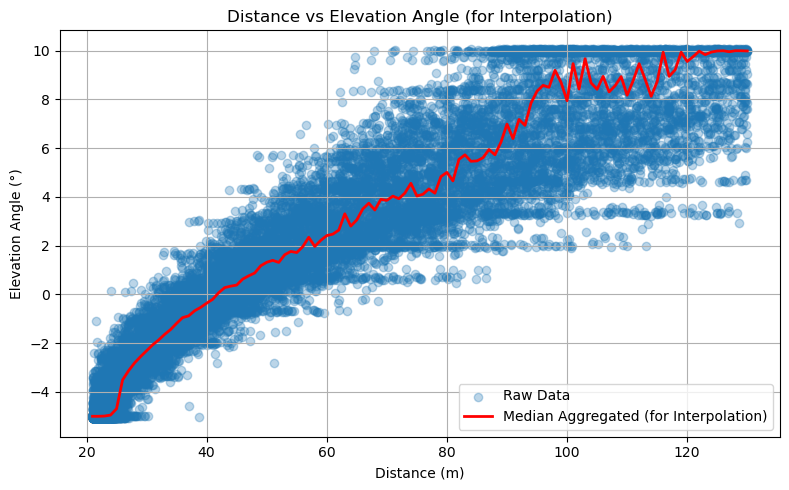

In [ ]:
# ── 시각화 ──
plt.figure(figsize=(8, 5))
plt.scatter(df['dist'], df['y_angle'], alpha=0.3, label='Raw Data')
plt.plot(distances, angles, color='red', label='Median Aggregated (for Interpolation)', linewidth=2)
plt.xlabel("Distance (m)")
plt.ylabel("Elevation Angle (°)")
plt.title("Distance vs Elevation Angle (for Interpolation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()